# Ornstein Uhlenbeck Instanton Calculation 

In this notebook we will use the MAM method outlined in [1] to calculate an instanton in the Ornstein Uhlenbeck SDE model. We will compare this to the analytic solution as well as the numerically integrated Euler-Lagrange Equations.

- [1] Weinan, E., Ren, W. and Vanden-Eijnden, E., 2004. Minimum action method for the study of rare events. Communications on pure and applied mathematics, 57(5), pp.637-656.

In [1]:
# Standard Package imports

import numpy as np
import numpy.linalg as la
import numpy.random as rm
import matplotlib.pyplot as plt

from mam import Mam_alg
from tqdm.notebook import tqdm

# Problem Definition & Parameter Choices

Here we define the drift function of the OU system and specify our parameter choices.

In [2]:
# F-W action Definition

def a(t, x, s):
    gamma, sigma = s
    return - gamma * x

In [3]:
# Parameter Specification

# OU Parameters
gamma = 0.5
sigma = 0.25
s = [gamma, sigma]
D = sigma **2
Dinv = 1/D

# Time
t0 = 0
tF = 10
dt = 0.1
steps = int((tF-t0)/dt)
time = np.arange(t0, tF, dt)

## MAM Set up

Here we define the initial instanton path for the minimisation problem, specify bounds and create a MAM algorithm object.

In [4]:
# Instanton Initialisation

initial_point = 0.1
final_point = 1.1

inst_ic = np.linspace(initial_point, final_point, len(time))

In [5]:
# --------------------------------------------------------------------------------
# Example Bounds Grid - Useful should you want to specify your own bounds
# --------------------------------------------------------------------------------

bnds = np.zeros((*inst_ic.shape, 2)) # indexed by Time, ndim, lower/upper

if (len(inst_ic.shape) == 1):
    shape = 1
else:
    shape = np.ones(inst_ic.shape[1])

# t = 0 Constraint
bnds[0,...,0] = initial_point - 0.0001 * shape # Lower
bnds[0,...,1] = initial_point + 0.0001 * shape # Upper

# Bounds for t \in (dt, T-dt)
bnds[1:-1, ..., 0] = - 5
bnds[1:-1, ..., 1] = 5

# t = T Constraint
bnds[-1,...,0] = final_point - 0.01 * shape
bnds[-1,...,1] = final_point + 0.01 * shape

In [6]:
# Object creation

# ou_mam = Mam_alg(a, s, inst_ic, time, Dinv) # default bounds
ou_mam = Mam_alg(a, s, inst_ic, time, Dinv, bnds=bnds) # specify bounds 

## Running MAM Algorithm

We run the algorithm for up to 10000 iterations/until convergence.

In [7]:
# Running for an initial 30000 Steps
options={'maxls': 10, 'maxiter': 10000, 'maxfun': 10000} 

In [8]:
result = ou_mam.run(options)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


## Comparison With Analytic Solution

We plot the MAM output alongside the known analytic solution.

In [9]:
def analytic_solution(time, x0, xf, s):
    gamma, sigma = s
    t0 = time[0]
    tf = time[-1]
    c1 = (xf - x0 * np.exp(- gamma * tf))/(2 * np.sinh(gamma * tf))
    c2 = x0 - c1
    return c1 * np.exp(gamma * time) + c2 * np.exp(-gamma * time)

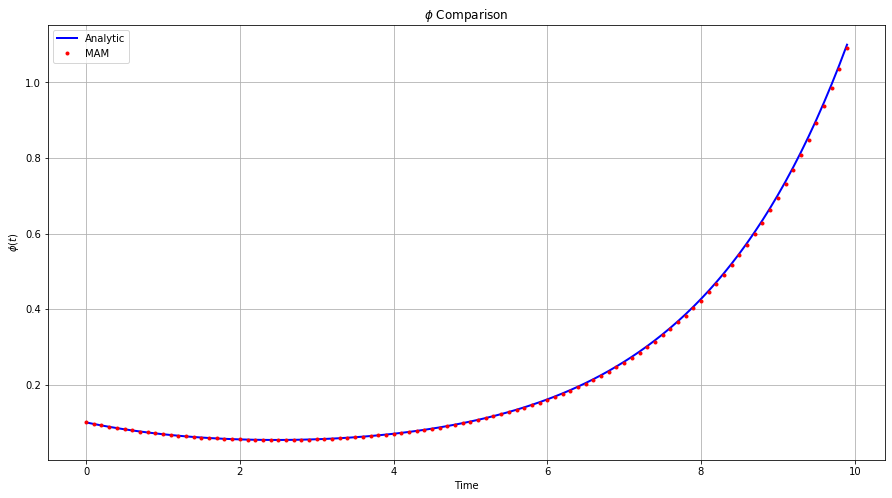

In [10]:
# Comparison Plot

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_title('$\\phi$ Comparison')
ax.plot(time,  analytic_solution(time, initial_point, final_point, s),'b', linewidth=2, label = 'Analytic')
ax.plot(time, ou_mam.instanton, 'r.', label = 'MAM')
ax.set_xlabel('Time')
ax.set_ylabel('$\\phi(t)$')
ax.legend()
fig.show()

## Calculating action For Nearby Paths

We compare the action for slightly perturb paths, create a histogram and check if our found path does indeed minimise.

In [16]:
from instanton_utility import *

In [17]:
# Creating A Load Of Random Paths to compare against

near_paths = [random_path(ou_mam.instanton, 0.01) for i in range(10000)] # Conclusion Different depending on paths
# near_paths = [random_path(ou_mam.instanton, 0.001) for i in range(10000)]

In [18]:
# Creating Object to Track Action Check

action_track = action_minimisation_checker(a, ou_mam.instanton, [s, time, Dinv])

In [19]:
# Doing the Comparison

for path in near_paths:
    action_track.compare(path)

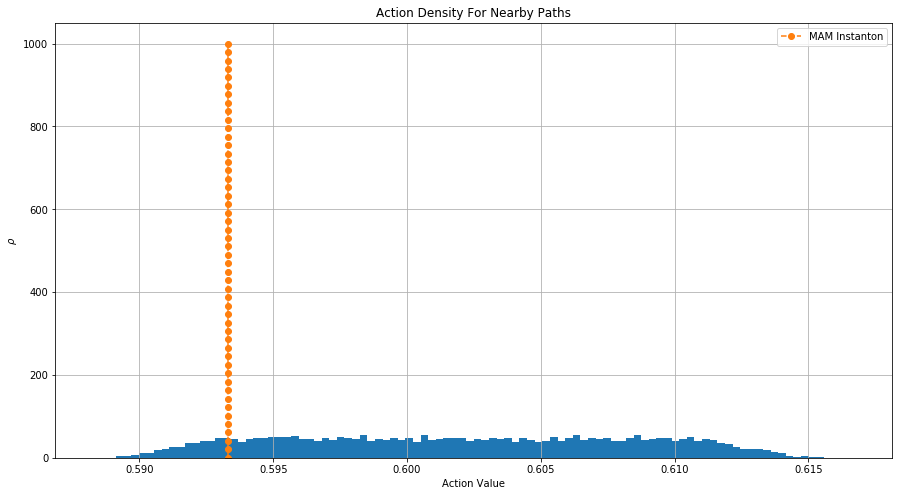

In [20]:
# Histogram 

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.hist(action_track.av_list, bins=100, density=True)
ax.plot(np.full_like(np.linspace(0, 1000), action_track.action_value), np.linspace(0, 1000), '--o', label='MAM Instanton')
ax.set_xlabel('Action Value')
ax.set_ylabel('$\\rho$')
ax.set_title('Action Density For Nearby Paths')
ax.legend()
fig.show()